In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
from bambi import Model

import matplotlib.pyplot as plt
%matplotlib inline
from glam.plots import plot_correlation

from analysis_functions import compute_gaze_influence_score, compute_mean_rt, compute_p_choose_best, make_sure_path_exists
from analysis_functions import q1, q3, iqr, std, se, add_best_chosen

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
np.random.seed(52) # from random.org

# 3.2. Absolute model fit (out of sample prediction)

## Load *observed* data (test set) GLAM out of sample *predictions*

In [5]:
all_data = pd.read_csv('data/data_aggregate.csv')
even = all_data[(all_data['trial'] % 2) == 0].reset_index(drop=True)
odd = all_data[(all_data['trial'] % 2) == 1].reset_index(drop=True)

In [6]:
even.head()

,subject,trial,rt,choice,item_value_0,item_value_1,item_value_2,gaze_0,gaze_1,gaze_2,n_items,dataset
0,0,0,3808.0,0.0,4.0,2.0,NaN,0.663725,0.336275,NaN,2,krajbich2010
1,0,2,1121.0,1.0,5.0,10.0,NaN,0.673317,0.326683,NaN,2,krajbich2010
2,0,4,1655.0,1.0,6.0,7.0,NaN,0.425759,0.574241,NaN,2,krajbich2010
3,0,6,2002.0,0.0,3.0,3.0,NaN,0.439809,0.560191,NaN,2,krajbich2010
4,0,8,1065.0,1.0,5.0,8.0,NaN,0.447368,0.552632,NaN,2,krajbich2010


In [7]:
odd.head()

,subject,trial,rt,choice,item_value_0,item_value_1,item_value_2,gaze_0,gaze_1,gaze_2,n_items,dataset
0,0,1,1913.0,0.0,3.0,2.0,NaN,0.466578,0.533422,NaN,2,krajbich2010
1,0,3,2051.0,1.0,6.0,6.0,NaN,0.464375,0.535625,NaN,2,krajbich2010
2,0,5,2504.0,0.0,6.0,2.0,NaN,0.524205,0.475795,NaN,2,krajbich2010
3,0,7,1426.0,0.0,6.0,5.0,NaN,1.000000,0.000000,NaN,2,krajbich2010
4,0,9,1209.0,0.0,6.0,8.0,NaN,0.429714,0.570286,NaN,2,krajbich2010


In [8]:
prediction_multiplicative_list = []
prediction_nobias_list = []

# join prediction dataframes
for subject in odd['subject'].unique():
    subject_pred_multiplicative = pd.read_csv(os.path.join('results', 'predictions', 'out_of_sample', 'multiplicative', 'prediction_{}_multiplicative_oos.csv'.format(subject)), index_col=0)
    subject_pred_nobias = pd.read_csv(os.path.join('results', 'predictions', 'out_of_sample', 'nobias', 'prediction_{}_nobias_oos.csv'.format(subject)), index_col=0)
    subject_pred_multiplicative['subject'] = subject
    subject_pred_nobias['subject'] = subject
    
    prediction_multiplicative_list.append(subject_pred_multiplicative)
    prediction_nobias_list.append(subject_pred_nobias)

prediction_multiplicative = pd.concat(prediction_multiplicative_list)
prediction_nobias = pd.concat(prediction_nobias_list)

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  from ipykernel import kernelapp as app


In [9]:
# discard trials with negative predicted RT
prediction_multiplicative = prediction_multiplicative[prediction_multiplicative['rt'] > 0].copy()
prediction_nobias = prediction_nobias[prediction_nobias['rt'] > 0].copy()

In [10]:
prediction_multiplicative.head()

,choice,dataset,gamma,gaze_0,gaze_1,gaze_2,item_value_0,item_value_1,item_value_2,n_items,repeat,rt,s,subject,t0,tau,trial,v
0,1.0,krajbich2010,0.65,0.466578,0.533422,NaN,3.0,2.0,NaN,2.0,0.0,1247.0,0.008368,0,0.0,0.44,1.0,0.000098
1,0.0,krajbich2010,0.65,0.466578,0.533422,NaN,3.0,2.0,NaN,2.0,1.0,3079.0,0.008368,0,0.0,0.44,1.0,0.000098
2,0.0,krajbich2010,0.65,0.466578,0.533422,NaN,3.0,2.0,NaN,2.0,2.0,2398.0,0.008368,0,0.0,0.44,1.0,0.000098
3,0.0,krajbich2010,0.65,0.466578,0.533422,NaN,3.0,2.0,NaN,2.0,3.0,960.0,0.008368,0,0.0,0.44,1.0,0.000098
4,0.0,krajbich2010,0.65,0.466578,0.533422,NaN,3.0,2.0,NaN,2.0,4.0,1515.0,0.008368,0,0.0,0.44,1.0,0.000098


In [11]:
prediction_multiplicative.tail()

,choice,dataset,gamma,gaze_0,gaze_1,gaze_2,item_value_0,item_value_1,item_value_2,n_items,repeat,rt,s,subject,t0,tau,trial,v
32645,1.0,tavares2017,0.01,0.299389,0.700611,NaN,4.0,7.0,NaN,2.0,45.0,3369.0,0.012259,117,0.0,0.25,1305.0,0.0001
32646,1.0,tavares2017,0.01,0.299389,0.700611,NaN,4.0,7.0,NaN,2.0,46.0,837.0,0.012259,117,0.0,0.25,1305.0,0.0001
32647,1.0,tavares2017,0.01,0.299389,0.700611,NaN,4.0,7.0,NaN,2.0,47.0,1461.0,0.012259,117,0.0,0.25,1305.0,0.0001
32648,1.0,tavares2017,0.01,0.299389,0.700611,NaN,4.0,7.0,NaN,2.0,48.0,1099.0,0.012259,117,0.0,0.25,1305.0,0.0001
32649,1.0,tavares2017,0.01,0.299389,0.700611,NaN,4.0,7.0,NaN,2.0,49.0,1151.0,0.012259,117,0.0,0.25,1305.0,0.0001


# Compute behavioral indices for observed data and predictions

In [12]:
def aggregate_subject_level(data, n_items):
    """
    Aggregates a single dataset to subject level
    """
    data = data.copy()
    
    # add best chosen variable
    data = add_best_chosen(data)
    
    # Summarize variables
    subject_summary = data.groupby('subject').agg({'rt': ['mean', std, 'min', 'max', se, q1, q3, iqr],
                                                   'best_chosen': 'mean'})
    # Influence of gaze on P(choice | value)
    subject_summary['gaze_influence'] = compute_gaze_influence_score(data, n_items=n_items)
    
    subject_summary['dataset'] = data.groupby('subject')['dataset'].head(1).values
    
    return subject_summary

In [13]:
odd_summary_list = []
pred_multiplicative_summary_list = []
pred_nobias_summary_list = []

for di, dataset in enumerate(odd['dataset'].unique()):
    odd_di = odd[odd['dataset'] == dataset].copy()
    n_items = odd_di['n_items'].unique()[0]
    
    odd_summary_di = aggregate_subject_level(odd_di, n_items=n_items)
    
    prediction_multiplicative_di = prediction_multiplicative[prediction_multiplicative['dataset'] == dataset].copy()
    prediction_nobias_di = prediction_nobias[prediction_nobias['dataset'] == dataset].copy()
    
    pred_multiplicative_summary_di = aggregate_subject_level(prediction_multiplicative_di, n_items=n_items)
    pred_nobias_summary_di = aggregate_subject_level(prediction_nobias_di, n_items=n_items)
    
    
    odd_summary_list.append(odd_summary_di)
    pred_multiplicative_summary_list.append(pred_multiplicative_summary_di)
    pred_nobias_summary_list.append(pred_nobias_summary_di)
    
odd_summary = pd.concat(odd_summary_list)
pred_multiplicative_summary = pd.concat(pred_multiplicative_summary_list)
pred_nobias_summary = pd.concat(pred_nobias_summary_list)

In [14]:
pred_multiplicative_summary.to_csv(os.path.join('results', 'predictions', 'out_of_sample', 'descriptives',
                                                'subject_summary_multiplicative_oos.csv'))
pred_nobias_summary.to_csv(os.path.join('results', 'predictions', 'out_of_sample', 'descriptives',
                                        'subject_summary_nobias_oos.csv'))

In [15]:
pred_nobias_summary.head()

rt                                                   \
                mean          std    min      max         se       q1   
subject                                                                 
0        1483.665778   535.686925  471.0   4115.0  11.295782  1117.25   
1        1502.737959   642.897107  423.0   4639.0  12.991134  1062.25   
2        4427.150800  2895.781847  664.0  28717.0  57.927224  2411.75   
3        1921.084545   504.680828  838.0   4738.0  10.762278  1617.75   
4        1740.098400   794.662275  500.0   5851.0  15.896425  1198.00   

                          best_chosen gaze_influence       dataset  
              q3      iqr        mean                               
subject                                                             
0        1733.00   615.75    0.890222      -0.002591  krajbich2010  
1        1790.75   728.50    0.780000       0.047497  krajbich2010  
2        5542.50  3130.75    0.846400       0.015188  krajbich2010  
3        2145.00   527.25    0.688636      -0.009199  krajbich2010  
4        2084.00   886.00    0.840800      -0.009003  krajbich2010

In [16]:
pred_multiplicative_summary.tail()

rt                                                          \
                mean          std    min      max         se      q1      q3   
subject                                                                        
113      2189.337197  2153.038110  286.0  17284.0  12.665149  1144.0  2389.0   
114      3341.584506  4984.396269  289.0  40259.0  27.691518  1380.0  3250.0   
115      1271.193815  1127.552996  243.0   9399.0   7.145720   771.0  1353.0   
116      2420.559574  2655.438637  317.0  21727.0  14.640130  1248.0  2556.0   
117      1458.849035   823.192480  267.0   6268.0   4.555819   944.0  1716.0   

                best_chosen gaze_influence      dataset  
            iqr        mean                              
subject                                                  
113      1245.0    0.855052       0.213650  tavares2017  
114      1870.0    0.826173       0.149680  tavares2017  
115       582.0    0.865663       0.287849  tavares2017  
116      1308.0    0.833769       0.326199  tavares2017  
117       772.0    0.770567       0.160005  tavares2017

# Mixed effects analysis of prediction biases

In [15]:
n_samples = 20000

## GLAM

In [16]:
# Reformat data for mixed model
mean_rt = np.concatenate([odd_summary['rt']['mean'].values,
                          pred_multiplicative_summary['rt']['mean'].values],
                         axis=0)
best_chosen = np.concatenate([odd_summary['best_chosen']['mean'].values,
                              pred_multiplicative_summary['best_chosen']['mean'].values],
                             axis=0)
gaze_influence = np.concatenate([odd_summary['gaze_influence'].values,
                                 pred_multiplicative_summary['gaze_influence'].values],
                                axis=0)

is_pred = np.concatenate([np.zeros(len(odd_summary)),
                          np.ones(len(pred_multiplicative_summary))],
                         axis=0)
dataset = np.concatenate([odd_summary['dataset'].values,
                          pred_multiplicative_summary['dataset'].values],
                         axis=0)

df = pd.DataFrame(dict(mean_rt=mean_rt,
                       best_chosen=best_chosen,
                       gaze_influence=gaze_influence,
                       is_pred=is_pred,
                       dataset=dataset))

df.head()

,mean_rt,best_chosen,gaze_influence,is_pred,dataset
0,1704.177778,0.822222,-0.020529,0.0,krajbich2010
1,1728.489796,0.673469,0.247233,0.0,krajbich2010
2,4078.660000,0.840000,0.028877,0.0,krajbich2010
3,1893.545455,0.704545,-0.022031,0.0,krajbich2010
4,1846.640000,0.840000,0.103622,0.0,krajbich2010


In [17]:
model = Model(df)
results_gaze_influence = model.fit('gaze_influence ~ is_pred',
                                   random=['is_pred|dataset'],
                                   categorical=['dataset'],
                                   samples=n_samples)

bias_analysis_glam_gaze_influence = results_gaze_influence.summary(ranefs=True)
bias_analysis_glam_gaze_influence.to_csv(os.path.join('results', 'mixed_effects_models', '3_abs_fit_bias_glam_gaze.csv'))
bias_analysis_glam_gaze_influence

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = -102.41:  46%|████▌     | 22940/50000 [00:18<00:21, 1248.43it/s] 
Convergence archived at 23000
Interrupted at 22,999 [45%]: Average Loss = 1,903
Sequential sampling (2 chains in 1 job)
NUTS: [gaze_influence_sd_interval__, is_pred|dataset_offset, is_pred|dataset_sd_log__, 1|dataset_offset, 1|dataset_sd_log__, is_pred, Intercept]
100%|██████████| 20500/20500 [03:24<00:00, 100.02it/s]
There were 245 divergences after tuning. Increase `target_accept` or reparameterize.
There were 451

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
is_pred|dataset[folke2016],0.005786,0.035830,-5.896349e-02,0.082816,548,1.002607
is_pred|dataset[krajbich2010],-0.009886,0.036081,-8.436952e-02,0.052604,429,1.004118
is_pred|dataset[krajbich2011],-0.000542,0.035602,-6.562848e-02,0.070636,396,1.003242
is_pred|dataset[tavares2017],-0.000806,0.035546,-6.716548e-02,0.074427,454,1.002978
is_pred|dataset_sd,0.035896,0.043408,5.817650e-07,0.112897,390,1.001424
gaze_influence_sd,0.143388,0.005333,1.340886e-01,0.152977,17016,1.000082
is_pred,-0.022051,0.035455,-8.253339e-02,0.042121,431,1.003064
Intercept,0.240041,0.047946,1.449192e-01,0.340855,765,1.004340
1|dataset[folke2016],0.081390,0.051597,-1.977554e-02,0.186141,813,1.004182
1|dataset[krajbich2010],-0.039964,0.049367,-1.455025e-01,0.056396,855,1.003416


In [18]:
results_mean_rt = model.fit('mean_rt ~ is_pred',
                            random=['is_pred|dataset'],
                            categorical=['dataset'],
                            samples=n_samples)

bias_analysis_glam_mean_rt = results_mean_rt.summary(ranefs=True)
bias_analysis_glam_mean_rt.to_csv(os.path.join('results', 'mixed_effects_models', '3_abs_fit_bias_glam_rt.csv'))
bias_analysis_glam_mean_rt

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 1,998.8: 100%|██████████| 50000/50000 [00:39<00:00, 1256.19it/s]
Finished [100%]: Average Loss = 1,998.7
Sequential sampling (2 chains in 1 job)
NUTS: [mean_rt_sd_interval__, is_pred|dataset_offset, is_pred|dataset_sd_log__, 1|dataset_offset, 1|dataset_sd_log__, is_pred, Intercept]
100%|██████████| 20500/20500 [12:08<00:00, 28.15it/s]
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
There were 249 divergences after tuning. Increase `target_accep

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
is_pred|dataset[folke2016],6.183238,193.424643,-418.517774,439.787199,2793,1.000765
is_pred|dataset[krajbich2010],-13.927032,181.691662,-425.657753,376.940723,2220,1.001247
is_pred|dataset[krajbich2011],-15.680129,189.891561,-454.574960,390.925857,2408,1.000426
is_pred|dataset[tavares2017],9.238693,194.331711,-414.882331,443.869557,2276,1.000827
is_pred|dataset_sd,226.660761,251.766992,0.016741,686.596580,1047,1.002964
is_pred,-9.132202,183.321313,-409.726087,344.452495,1592,1.002040
Intercept,2944.900317,743.890997,1488.746634,4416.812658,1052,1.002927
1|dataset[folke2016],2370.965658,751.982456,948.822934,3931.385639,1118,1.002462
1|dataset[krajbich2010],-781.187041,748.869686,-2221.514423,752.620702,1086,1.002634
1|dataset[krajbich2011],-521.260399,750.008881,-2026.287790,944.050806,1107,1.002577


In [19]:
results_best_chosen = model.fit('best_chosen ~ is_pred',
                                random=['is_pred|dataset'],
                                categorical=['dataset'],
                                samples=n_samples)

bias_analysis_glam_best_chosen = results_best_chosen.summary(ranefs=True)
bias_analysis_glam_best_chosen.to_csv(os.path.join('results', 'mixed_effects_models', '3_abs_fit_bias_glam_best_chosen.csv'))
bias_analysis_glam_best_chosen

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = -189.34:  45%|████▌     | 22603/50000 [00:18<00:22, 1221.66it/s]
Convergence archived at 22700
Interrupted at 22,699 [45%]: Average Loss = 3,005.6
Sequential sampling (2 chains in 1 job)
NUTS: [best_chosen_sd_interval__, is_pred|dataset_offset, is_pred|dataset_sd_log__, 1|dataset_offset, 1|dataset_sd_log__, is_pred, Intercept]
100%|██████████| 20500/20500 [04:59<00:00, 68.51it/s]
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 dive

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
is_pred|dataset[folke2016],-0.006850,0.025211,-6.294348e-02,0.042713,14227,1.000141
is_pred|dataset[krajbich2010],0.010806,0.025016,-3.388074e-02,0.068218,12820,0.999994
is_pred|dataset[krajbich2011],-0.008073,0.025001,-6.704170e-02,0.036807,13663,1.000039
is_pred|dataset[tavares2017],0.003912,0.024995,-4.385866e-02,0.061252,13825,1.000016
is_pred|dataset_sd,0.029641,0.031191,6.969388e-07,0.088930,8430,0.999975
is_pred,-0.022139,0.023374,-7.026238e-02,0.023049,12781,1.000022
Intercept,0.767203,0.051055,6.602676e-01,0.868185,7143,1.000083
1|dataset[folke2016],-0.110091,0.052479,-2.205632e-01,-0.007200,7728,1.000155
1|dataset[krajbich2010],0.050345,0.051821,-5.546481e-02,0.154463,6947,1.000062
1|dataset[krajbich2011],-0.031545,0.052142,-1.387941e-01,0.072376,7432,1.000085


## No Bias

In [20]:
# Prepare data for mixed model
mean_rt = np.concatenate([odd_summary['rt']['mean'].values,
                          pred_nobias_summary['rt']['mean'].values],
                         axis=0)
best_chosen = np.concatenate([odd_summary['best_chosen']['mean'].values,
                              pred_nobias_summary['best_chosen']['mean'].values],
                             axis=0)
gaze_influence = np.concatenate([odd_summary['gaze_influence'].values,
                                 pred_nobias_summary['gaze_influence'].values],
                                axis=0)

is_pred = np.concatenate([np.zeros(len(odd_summary)),
                          np.ones(len(pred_nobias_summary))],
                         axis=0)
dataset = np.concatenate([odd_summary['dataset'].values,
                          pred_nobias_summary['dataset'].values],
                         axis=0)

df = pd.DataFrame(dict(mean_rt=mean_rt,
                       best_chosen=best_chosen,
                       gaze_influence=gaze_influence,
                       is_pred=is_pred,
                       dataset=dataset))

df.head()

,mean_rt,best_chosen,gaze_influence,is_pred,dataset
0,1704.177778,0.822222,-0.020529,0.0,krajbich2010
1,1728.489796,0.673469,0.247233,0.0,krajbich2010
2,4078.660000,0.840000,0.028877,0.0,krajbich2010
3,1893.545455,0.704545,-0.022031,0.0,krajbich2010
4,1846.640000,0.840000,0.103622,0.0,krajbich2010


In [21]:
model = Model(df)
results_gaze_influence = model.fit('gaze_influence ~ is_pred',
                                   random=['is_pred|dataset'],
                                   categorical=['dataset'],
                                   samples=n_samples)

bias_analysis_nobias_gaze_influence = results_gaze_influence.summary(ranefs=True)
bias_analysis_nobias_gaze_influence.to_csv(os.path.join('results', 'mixed_effects_models', '3_abs_fit_bias_nobias_gaze.csv'))
bias_analysis_nobias_gaze_influence

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = -167.28:  51%|█████     | 25351/50000 [00:19<00:19, 1271.14it/s]
Convergence archived at 25400
Interrupted at 25,399 [50%]: Average Loss = 1,380.6
Sequential sampling (2 chains in 1 job)
NUTS: [gaze_influence_sd_interval__, is_pred|dataset_offset, is_pred|dataset_sd_log__, 1|dataset_offset, 1|dataset_sd_log__, is_pred, Intercept]
100%|██████████| 20500/20500 [04:12<00:00, 81.16it/s]
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 196 

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
is_pred|dataset[folke2016],-0.064004,0.052485,-0.175414,0.022771,1838,1.000588
is_pred|dataset[krajbich2010],0.015505,0.042666,-0.078539,0.105360,2085,1.000359
is_pred|dataset[krajbich2011],-0.010303,0.043774,-0.109497,0.075273,1854,1.000669
is_pred|dataset[tavares2017],0.017728,0.043824,-0.075261,0.111455,2190,1.000292
is_pred|dataset_sd,0.068428,0.048503,0.000006,0.164987,2123,1.000267
gaze_influence_sd,0.108833,0.005229,0.098903,0.119399,40000,1.000112
is_pred,-0.227179,0.041045,-0.308115,-0.131912,1640,1.000545
Intercept,0.236765,0.036684,0.156990,0.311178,1972,1.001390
1|dataset[folke2016],0.069280,0.041886,-0.005757,0.161977,3436,1.000709
1|dataset[krajbich2010],-0.029083,0.038281,-0.109351,0.049900,2128,1.001224


In [22]:
results_mean_rt = model.fit('mean_rt ~ is_pred',
                            random=['is_pred|dataset'],
                            categorical=['dataset'],
                            samples=n_samples)

bias_analysis_nobias_mean_rt = results_mean_rt.summary(ranefs=True)
bias_analysis_nobias_mean_rt.to_csv(os.path.join('results', 'mixed_effects_models', '3_abs_fit_bias_nobias_rt.csv'))
bias_analysis_nobias_mean_rt

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,004.7: 100%|██████████| 50000/50000 [00:38<00:00, 1282.19it/s]
Finished [100%]: Average Loss = 2,004.7
Sequential sampling (2 chains in 1 job)
NUTS: [mean_rt_sd_interval__, is_pred|dataset_offset, is_pred|dataset_sd_log__, 1|dataset_offset, 1|dataset_sd_log__, is_pred, Intercept]
100%|██████████| 20500/20500 [15:17<00:00, 22.34it/s]
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
There were 223 divergences after tuning. Increase `target_accep

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
is_pred|dataset[folke2016],-2.526226,195.730639,-442.559707,419.515893,5191,1.000126
is_pred|dataset[krajbich2010],-17.880493,184.558756,-431.111345,369.979637,3924,1.000357
is_pred|dataset[krajbich2011],5.378380,189.572513,-407.977578,422.470261,4321,1.000615
is_pred|dataset[tavares2017],5.896717,193.936155,-413.332875,443.886545,4985,1.000215
is_pred|dataset_sd,227.115535,246.036493,0.000107,691.711755,2288,0.999977
is_pred,14.652198,185.818392,-354.925326,412.874884,2788,1.001059
Intercept,2930.310779,795.489915,1289.818888,4439.705363,923,1.000255
1|dataset[folke2016],2374.522983,804.441179,828.028235,4005.160960,966,1.000341
1|dataset[krajbich2010],-771.767522,800.579567,-2365.051578,796.446894,948,1.000307
1|dataset[krajbich2011],-487.608329,802.376406,-2062.665692,1115.052138,948,1.000252


In [23]:
results_best_chosen = model.fit('best_chosen ~ is_pred',
                                random=['is_pred|dataset'],
                                categorical=['dataset'],
                                samples=n_samples)

bias_analysis_nobias_best_chosen = results_best_chosen.summary(ranefs=True)
bias_analysis_nobias_best_chosen.to_csv(os.path.join('results', 'mixed_effects_models', '3_abs_fit_bias_nobias_best_chosen.csv'))
bias_analysis_nobias_best_chosen

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = -207.03:  50%|████▉     | 24812/50000 [00:19<00:20, 1257.76it/s] 
Convergence archived at 24900
Interrupted at 24,899 [49%]: Average Loss = 2,736.6
Sequential sampling (2 chains in 1 job)
NUTS: [best_chosen_sd_interval__, is_pred|dataset_offset, is_pred|dataset_sd_log__, 1|dataset_offset, 1|dataset_sd_log__, is_pred, Intercept]
100%|██████████| 20500/20500 [06:05<00:00, 56.08it/s]
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 div

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
is_pred|dataset[folke2016],-0.009518,0.024767,-0.067449,0.034684,10982,0.999993
is_pred|dataset[krajbich2010],0.014496,0.025427,-0.030271,0.072145,7709,0.999977
is_pred|dataset[krajbich2011],-0.003072,0.023852,-0.054723,0.046599,8274,1.000024
is_pred|dataset[tavares2017],-0.001081,0.024223,-0.052884,0.051231,8060,0.999978
is_pred|dataset_sd,0.029804,0.029438,0.000001,0.088121,7866,0.999981
is_pred,0.001294,0.022764,-0.044332,0.048286,7507,0.999988
Intercept,0.769141,0.049428,0.669974,0.869689,7060,0.999981
1|dataset[folke2016],-0.113719,0.050585,-0.214910,-0.011406,7618,0.999978
1|dataset[krajbich2010],0.049531,0.050381,-0.050653,0.152601,7309,0.999980
1|dataset[krajbich2011],-0.030279,0.050391,-0.132406,0.071070,7459,1.000000


# Figure 5

In [17]:
import matplotlib.patches as mpatches

In [20]:
def figure_5(observed, multiplicative, nobias,
             figsize=(7.5, 4.5), colors=None, fontsize=8, alpha=1.0):

    datasets = ['krajbich2010', 'krajbich2011', 'folke2016', 'tavares2017']
    
    if colors is None:
        colors = np.array(['C{}'.format(i)
                           for i in range(observed['dataset'].unique().size)])
    color_idx = pd.Categorical(observed['dataset'], categories=datasets, ordered=True).codes.astype(int)
    
    fig, axs = plt.subplots(2, 3, figsize=figsize, sharex='col', sharey='col')
    
    for m, model in enumerate([multiplicative, nobias]):

        # a) Mean RT
        axs[m, 0].scatter(observed['rt']['mean'],
                          model['rt']['mean'],
                          color=colors[color_idx],
                          marker='+',
                          alpha=alpha)
        axs[m, 0].set_xticks(np.arange(0, 10000, 2000))
        axs[m, 0].set_yticks(np.arange(0, 10000, 2000))
        axs[m, 0].set_xlim(0, 9000)
        axs[m, 0].set_ylim(0, 9000)

        
        # b) P(choose best)
        axs[m, 1].scatter(observed['best_chosen']['mean'],
                          model['best_chosen']['mean'],
                          color=colors[color_idx],
                          marker='+',
                          alpha=alpha)
        axs[m, 1].set_xticks(np.arange(0.4, 1.1, 0.2))
        axs[m, 1].set_yticks(np.arange(0.4, 1.1, 0.2))
        axs[m, 1].set_xlim(0.3, 1.0)
        axs[m, 1].set_ylim(0.3, 1.0)


    
        # c) Gaze Influence
        axs[m, 2].scatter(observed['gaze_influence'],
                          model['gaze_influence'],
                          color=colors[color_idx],
                          marker='+',
                          alpha=alpha)
        axs[m, 2].set_xticks(np.arange(-0.2, 1.1, 0.2))
        axs[m, 2].set_yticks(np.arange(-0.2, 1.1, 0.2))
        axs[m, 2].set_xlim(-0.25, 0.85)
        axs[m, 2].set_ylim(-0.25, 0.85)



    axs[0, 0].set_ylabel('GLAM\n\nPredicted', fontsize=fontsize)
    axs[1, 0].set_ylabel('No-Bias\n\nPredicted', fontsize=fontsize)

    axs[0, 0].set_title('Mean RT (ms)', fontsize=fontsize)
    axs[0, 1].set_title('P(choose best)', fontsize=fontsize)
    axs[0, 2].set_title('Gaze influence\non P(choice | value)', fontsize=fontsize)
     
    axs[1, 0].set_xlabel('Observed', fontsize=fontsize)
    axs[1, 1].set_xlabel('Observed', fontsize=fontsize)
    axs[1, 2].set_xlabel('Observed', fontsize=fontsize)
    
    patches = [mpatches.Rectangle((0, 0), 0.5, 1, fc="C{}".format(i))
               for i in range(len(datasets))]

    axs[0, 0].legend(patches,
                     ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'],
                     loc='upper left',
                     handlelength=1, handleheight=1,
                     fontsize=6,
                     frameon=False)

    # Labels
    for label, ax in zip(list('abcdef'), axs.ravel()):
        ax.text(-0.2, 1.2, label, transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Font sizes
        ax.tick_params(axis='both', labelsize=8)

        # Plot diagonal
        ax.plot(ax.get_xlim(), ax.get_xlim(), linewidth=1, color='black', alpha=1.0, zorder=-1)
        
    
    fig.tight_layout(pad=2)

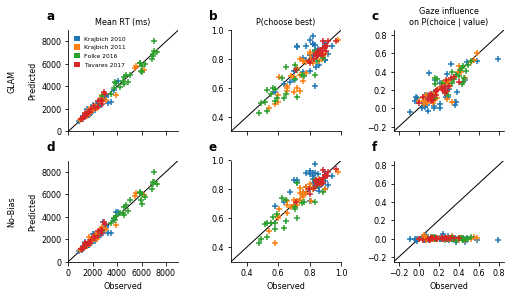

In [21]:
figure_5(odd_summary, pred_multiplicative_summary, pred_nobias_summary, alpha=1);
plt.savefig('results/figures/figure_5_absolute_model_fit.png', dpi=330, bbox_inches='tight')
plt.show()